# MSE 546 Project
### Bank Customer Churn Prediction 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imbpipeline

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# load data

In [15]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

print(df_train.shape)
print(df_test.shape)

df_train.head(5)

(165034, 14)
(110023, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


# EDA

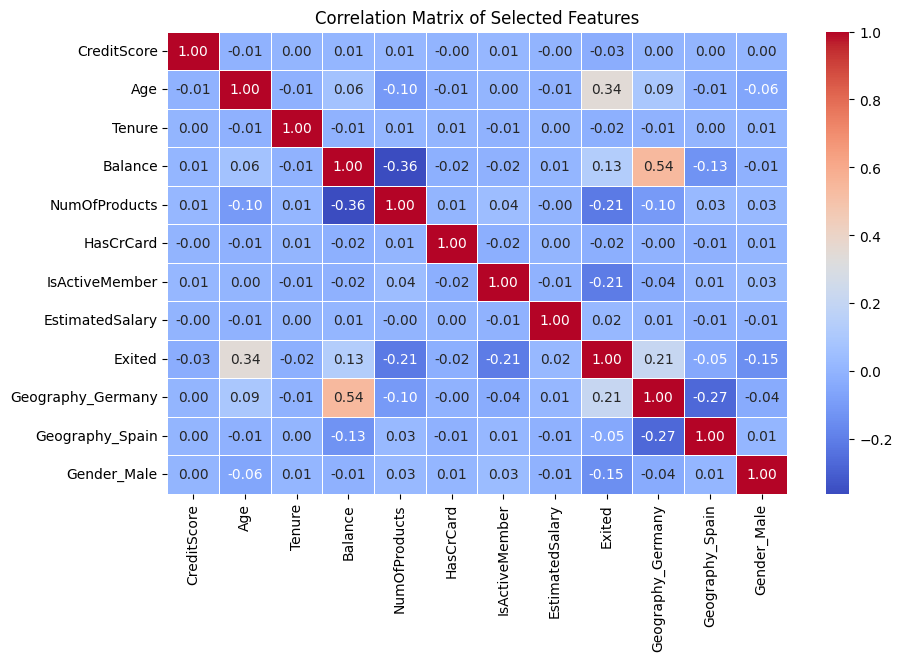

In [16]:
features = [
    "CreditScore", 
    "Geography", 
    "Gender", 
    "Age", 
    "Tenure", 
    "Balance", 
    "NumOfProducts", 
    "HasCrCard", 
    "IsActiveMember", 
    "EstimatedSalary",
      "Exited"
]

df_encoded = pd.get_dummies(df_train[features], drop_first=True)
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()

# class imbalance

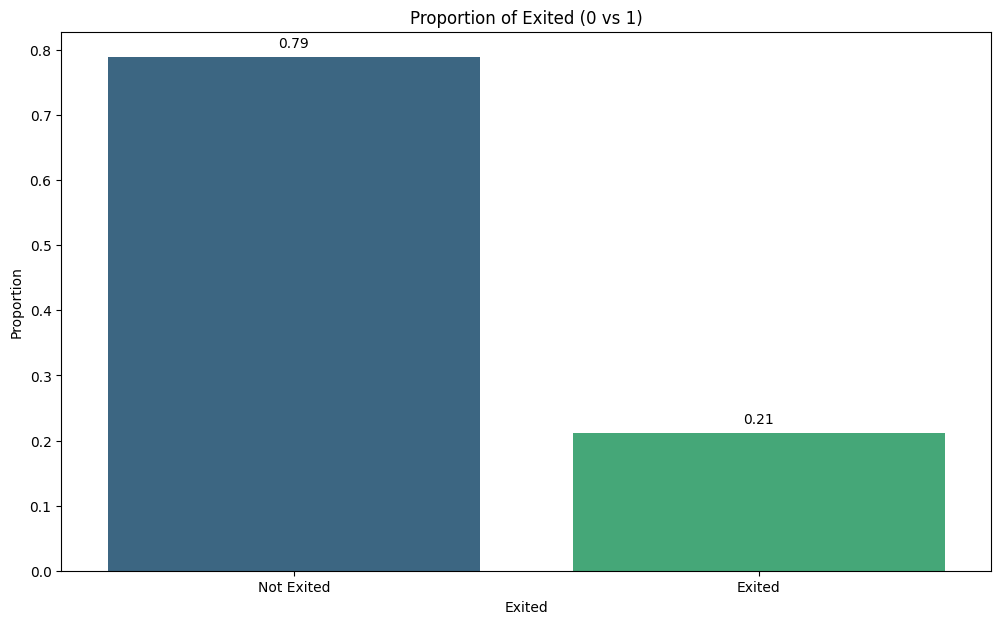

In [17]:
exited_proportion = df_train['Exited'].value_counts(normalize=True)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x=exited_proportion.index, y=exited_proportion.values, hue=exited_proportion.index, palette='viridis', legend=False)
plt.title('Proportion of Exited (0 vs 1)')
plt.xlabel('Exited')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['Not Exited', 'Exited'])

for i, proportion in enumerate(exited_proportion.values):
    ax.text(i, proportion + 0.01, f'{proportion:.2f}', ha='center', va='bottom')

plt.show()

# data cleaning

In [18]:
def clean(df):
    df = df.dropna()
    df = df.drop_duplicates()
    return df

# Apply cleaning function to both datasets
df_train = clean(df_train)
df_test = clean(df_test)
print(df_train.shape)

(165034, 14)


# data preparation

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(columns=['id', 'CustomerId', 'Surname', 'Exited']),
    df_train['Exited'],
    test_size=0.2,
    random_state=42
)

num_features = X_train.select_dtypes(include=['int64', 'float64', 'boolean']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# universal prediction code:

In [20]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_custom = (y_pred_proba >= threshold).astype(int)

    # Evaluate model
    print("Accuracy:", accuracy_score(y_test, y_pred_custom))
    print(classification_report(y_test, y_pred_custom))

    # Precision, Recall, F1 Score, and AUC
    precision = precision_score(y_test, y_pred_custom)
    recall = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred_custom)

    # Normalize the confusion matrix to show percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Plot the confusion matrix with percentages
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Not Churn', 'Predicted Churn'], 
                yticklabels=['Actual Not Churn', 'Actual Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

# logistic regression

Accuracy: 0.7515981458478505
              precision    recall  f1-score   support

           0       0.92      0.75      0.83     26052
           1       0.45      0.74      0.56      6955

    accuracy                           0.75     33007
   macro avg       0.68      0.75      0.69     33007
weighted avg       0.82      0.75      0.77     33007

Precision: 0.4461
Recall: 0.7403
F1 Score: 0.5567
AUC: 0.8193


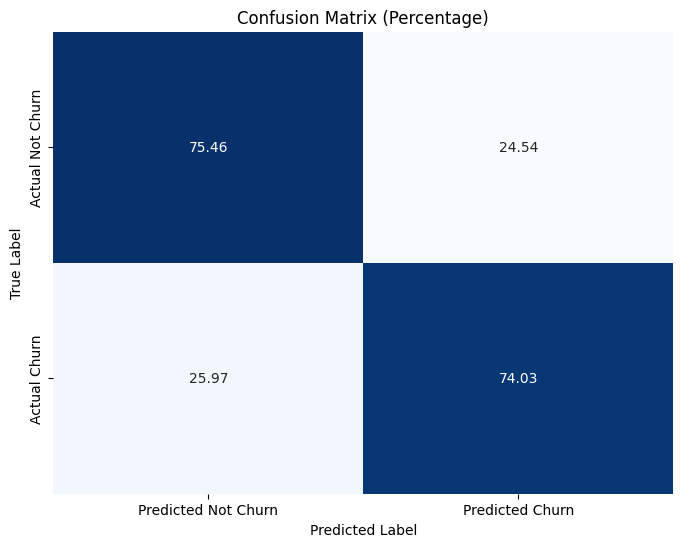

In [21]:
# resampler = SMOTEENN(random_state=42)
undersampler = RandomUnderSampler(random_state=42)
feature_selector = SelectFromModel(LogisticRegression(random_state=42))

model = imbpipeline([
    ('preprocessor', preprocessor),
    # ('resampler', resampler),  
    ('undersampler', undersampler),
    # ('feature_selection', feature_selector),  
    ('classifier', LogisticRegression(random_state=42))  
])

model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

# SVM

Accuracy: 0.6604659617656861
              precision    recall  f1-score   support

           0       0.94      0.61      0.74     26052
           1       0.37      0.86      0.52      6955

    accuracy                           0.66     33007
   macro avg       0.65      0.73      0.63     33007
weighted avg       0.82      0.66      0.69     33007

Precision: 0.3685
Recall: 0.8566
F1 Score: 0.5153
AUC: 0.7766


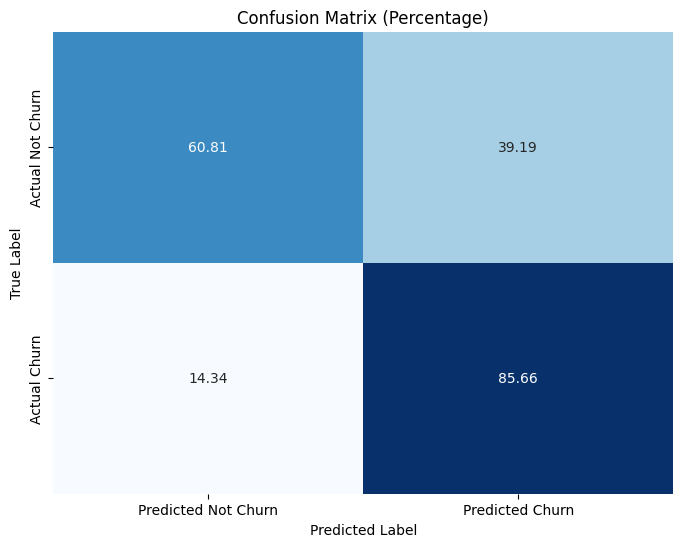

In [22]:
# resampler = SMOTEENN(random_state=42)
undersampler = RandomUnderSampler(random_state=42)
feature_selector = SelectFromModel(XGBClassifier(n_estimators=200, max_depth=10, random_state=42))

scaler = StandardScaler()

model = imbpipeline([
    ('preprocessor', preprocessor),
    ('scaler', scaler),
    # ('resampler', resampler),  
    ('undersampler', undersampler),
    ('feature_selection', feature_selector),  
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
])

model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

# random forest

Accuracy: 0.8038294907140909
              precision    recall  f1-score   support

           0       0.94      0.80      0.87     26052
           1       0.52      0.80      0.63      6955

    accuracy                           0.80     33007
   macro avg       0.73      0.80      0.75     33007
weighted avg       0.85      0.80      0.82     33007

Precision: 0.5225
Recall: 0.8017
F1 Score: 0.6327
AUC: 0.8868


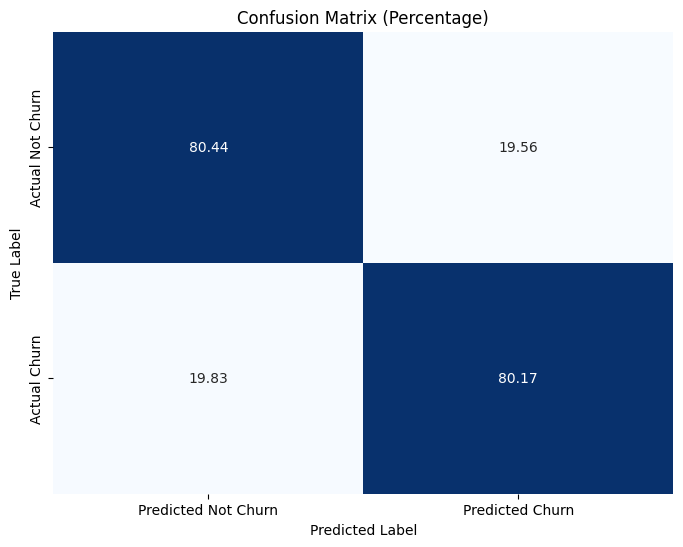

In [23]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))

model = imbpipeline([
    ('preprocessor', preprocessor),
    ('undersampler', undersampler),
    # ('feature_selection', feature_selector),  
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))  
])

model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

# LightGBM

[LightGBM] [Info] Number of positive: 87111, number of negative: 69948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2634
[LightGBM] [Info] Number of data points in the train set: 157059, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554639 -> initscore=0.219431
[LightGBM] [Info] Start training from score 0.219431
Accuracy: 0.828127366922168
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     26052
           1       0.57      0.76      0.65      6955

    accuracy                           0.83     33007
   macro avg       0.75      0.80      0.77     33007
weighted avg       0.85      0.83      0.84     33007

Precision: 0.5693
Recall: 0.7573
F1 Score: 0.6500
AUC: 0.8885


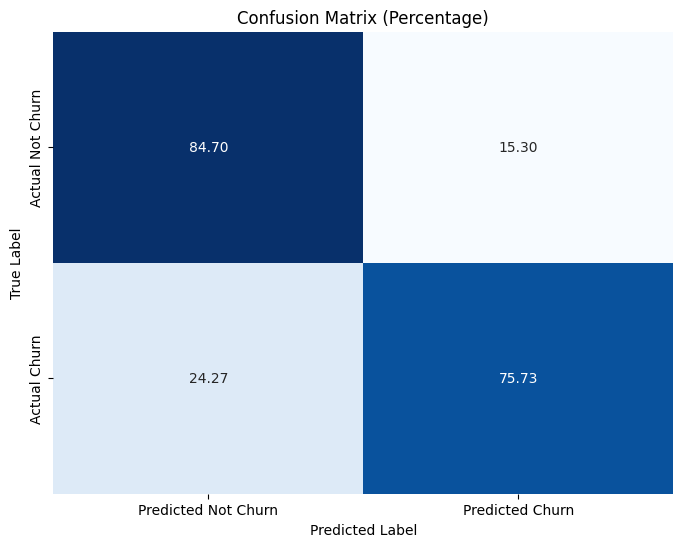

In [24]:
resampler = SMOTEENN(random_state=42)
undersampler = RandomUnderSampler(random_state=42)
feature_selector = SelectFromModel(LGBMClassifier(n_estimators=200, max_depth=10, random_state=42))

# Define an improved model pipeline with XGBoost
model = imbpipeline([
    ('preprocessor', preprocessor),
    ('resampler', resampler),  
    # ('undersampler', undersampler),
    # ('feature_selection', feature_selector),  
    ('classifier', LGBMClassifier(n_estimators=200, max_depth=10, random_state=42))  
])

model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

# xgboost

Accuracy: 0.7974672039264399
              precision    recall  f1-score   support

           0       0.93      0.81      0.86     26052
           1       0.51      0.76      0.61      6955

    accuracy                           0.80     33007
   macro avg       0.72      0.78      0.74     33007
weighted avg       0.84      0.80      0.81     33007

Precision: 0.5131
Recall: 0.7619
F1 Score: 0.6132
AUC: 0.8645


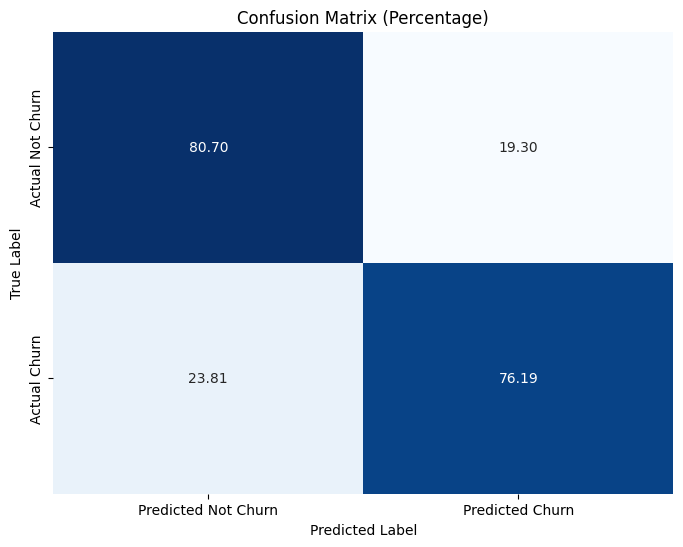

In [25]:
resampler = SMOTEENN(random_state=42)
undersampler = RandomUnderSampler(random_state=42)
feature_selector = SelectFromModel(XGBClassifier(n_estimators=200, max_depth=10, random_state=42))

model = imbpipeline([
    ('preprocessor', preprocessor),
    ('resampler', resampler),  
    # ('undersampler', undersampler),
    ('feature_selection', feature_selector),  
    ('classifier', XGBClassifier(n_estimators=200, max_depth=10, random_state=42,))  
])

model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

In [26]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

if 'feature_selection' in model.named_steps:
    selected_features_indices = model.named_steps['feature_selection'].get_support(indices=True)
    selected_feature_names = feature_names[selected_features_indices]
else:
    selected_feature_names = feature_names

xgb_clf = model.named_steps['classifier']
booster = xgb_clf.get_booster()
booster.feature_names = selected_feature_names.tolist()

xgb.plot_importance(booster, max_num_features=20)
plt.show()

NameError: name 'xgb' is not defined